# Matrix Multiplication from the foundations:

The *foundations* we'll assume throughout this course are: 
- Python
- matplotlib
- The Python standard library
- Jupyter Notebooks and nbdev

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

We will now need to get the data:

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok = True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -l data

total 16656
-rw-r--r-- 1 kiriyama kiriyama 17051982 Jul 27 19:25 mnist.pkl.gz


In [5]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = 'latin-1')

In [6]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [7]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [8]:
val_iter = chunks(vals,5)

In [9]:
next(val_iter)

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

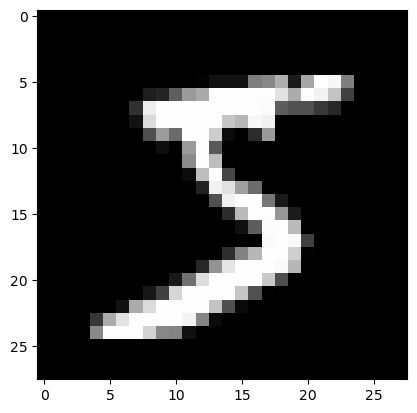

In [10]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1,28)))


In [11]:
from itertools import islice

In [12]:
it = iter(vals)

In [13]:
list(islice(it,5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [14]:
list(islice(it,5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [15]:
list(islice(it,5))

[]

In [16]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it,28)),[]))


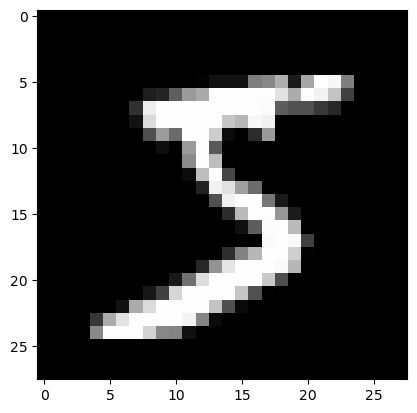

In [17]:
plt.imshow(img)

## Matrix and Tensor

In [18]:
img[20][15]

0.98828125

In [19]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [20]:
m = Matrix(img)
m[20,15]

0.98828125

In [21]:
import torch
from torch import tensor

In [22]:
tensor([1,2,3])

tensor([1, 2, 3])

In [23]:
tens = tensor(img)

In [24]:
tens[20,15]

tensor(0.9883)

In [25]:
x_train, x_valid, y_train, y_valid = map(tensor, (x_train,x_valid,y_train,y_valid))

In [26]:
x_train.shape

torch.Size([50000, 784])

In [27]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

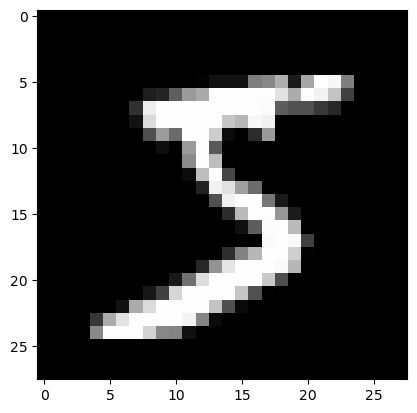

In [28]:
plt.imshow(imgs[0])

In [29]:
imgs[0,20,15]

tensor(0.9883)

In [30]:
n, c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [31]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

## Random Numbers

Based on the Whichmann Hill algorithm used before Python 2.3

In [32]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [33]:
seed(42)
rnd_state

(43, 1, 1)

In [34]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [35]:
rand(),rand(),rand()

(0.25420336316883324, 0.46884405296716114, 0.19540525690312815)

In [36]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.28886109883281286
In child: 0.28886109883281286


In [37]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.3221])
In child: tensor([0.3221])


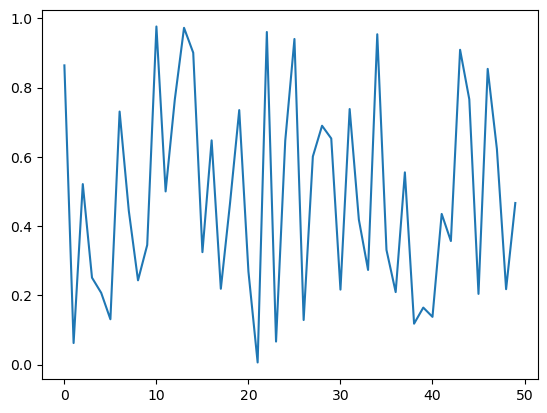

In [38]:
plt.plot([rand() for _ in range(50)]);

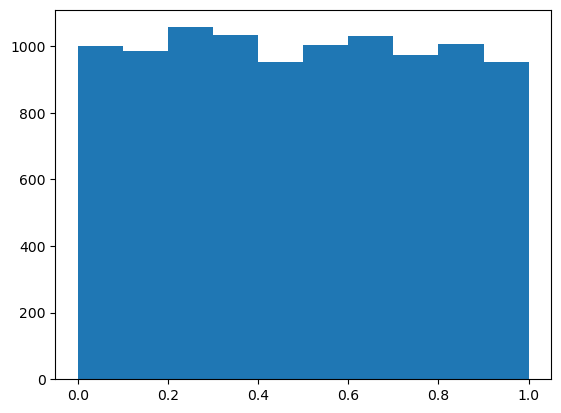

In [39]:
plt.hist([rand() for _ in range(10000)]);

In [40]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

3.37 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 12.10 times longer than the fastest. This could mean that an intermediate result is being cached.
127 µs ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Matrix multiplication

In [42]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [43]:
m1 = x_valid[:5]
m2 = weights 

In [44]:
m1.shape, m2.shape 

(torch.Size([5, 784]), torch.Size([784, 10]))

In [45]:
ar, ac = m1.shape
br, bc = m2.shape 
(ar,ac), (br,bc)

((5, 784), (784, 10))

In [46]:
t1 = torch.zeros(ar,bc)
t1.shape

torch.Size([5, 10])

In [47]:
for i in range(ar): # 5
    for j in range(bc): # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]


In [48]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [49]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [50]:
def matmul(a,b):
    (ar, ac), (br, bc) = a.shape, b.shape 
    c = torch.zeros(ar,bc)

    for i in range(ar): # 5
        for j in range(bc): # 10
            for k in range(ac): # 784
                c[i,j] += a[i,k] * b[k,j]
    return c


In [51]:
%time _= matmul(m1,m2)

CPU times: user 818 ms, sys: 9.58 ms, total: 828 ms
Wall time: 828 ms


# Numba

In [52]:
from numba import njit

In [53]:
@njit
def dot(a,b):
    res = 0
    for i in range(len(a)):
        res += a[i] * b[i]
    return res

In [54]:
from numpy import array

In [55]:
%time dot(array([1,2,3]), array([4,5,6]))

CPU times: user 358 ms, sys: 50.9 ms, total: 409 ms
Wall time: 637 ms


32

In [56]:
%time dot(array([1,2,3]), array([4,5,6]))

CPU times: user 18 µs, sys: 3 µs, total: 21 µs
Wall time: 23.1 µs


32

In [57]:
def matmul(a,b):
    (ar, ac) ,(br, bc) = a.shape, b.shape
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = dot(a[i,:],b[:,j])
    return c

In [58]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [59]:
m1a,m2a = m1.numpy(),m2.numpy()

In [60]:
from fastcore.test import *

In [61]:
test_close(t1,matmul(m1a, m2a))

In [62]:
%timeit -n 50 matmul(m1a,m2a)

485 µs ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


# Elementwise Ops

In [63]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [64]:
a + b

tensor([12., 14.,  3.])

In [65]:
(a < b).float().mean()

tensor(0.67)

In [66]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [67]:
sf = (m*m).sum()
sf.sqrt()

tensor(16.88)

In [68]:
def matmul(a,b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [69]:
test_close(t1,matmul(m1, m2))

In [70]:
%timeit -n 50 _=matmul(m1, m2)

1.08 ms ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [71]:
c = tensor([10.,20, 30]); c

tensor([10., 20., 30.])

In [72]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [73]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [74]:
digit = m1[0]

In [75]:
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [76]:
digit[:,None].shape

torch.Size([784, 1])

In [77]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [78]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [79]:
def matmul(a,b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [80]:
test_close(t1,matmul(m1, m2))

In [81]:
m1[0,:,None].expand_as(m2).shape

torch.Size([784, 10])

In [82]:
t2 = torch.randn(3,4)
t2

tensor([[    -0.42,      0.19,     -0.36,      0.00],
        [     0.06,      1.93,      0.28,     -0.50],
        [    -0.58,      0.80,      0.36,     -1.26]])

In [83]:
t2.sum(dim=0)

tensor([-0.94,  2.92,  0.28, -1.75])

In [84]:
%timeit -n 50 _=matmul(m1, m2)

211 µs ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [85]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [86]:
tr.shape

torch.Size([50000, 10])

In [87]:
%time _=matmul(x_train, weights)

CPU times: user 2.47 s, sys: 30.5 ms, total: 2.51 s
Wall time: 1.91 s


# Einstein summation

In [88]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [90]:
mr = torch.einsum('ik,kj -> ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [92]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [95]:
torch.einsum('ik,kj -> ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [96]:
def matmul(a,b): return torch.einsum('ik,kj -> ij', a, b)

In [97]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [99]:
%timeit -n 5 _=matmul(x_train, weights)

12.3 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


# pytorch op

we can use pytorch's function or operator directly for matrix multiplication

In [100]:
test_close(tr, x_train@weights, eps = 1e-3)

In [101]:
%timeit -n 5 _=torch.matmul(x_train, weights)

12 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


# CUDA:

In [102]:
def matmul(grid, a, b, c):
    i, j = grid
    tmp = 0.
    if i < c.shape[0] and j < c.shape[1]:
        for k in range(a.shape[1]):
            tmp += a[i,k] * b[k,j]
        c[i,j] = tmp
    

In [104]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [105]:
def launch_kernel(kernel, x_grid, y_grid, *args, **kwargs):
    for i in range(x_grid):
        for j in range(y_grid):
            kernel((i,j),*args, **kwargs)
res = torch.zeros(ar,bc)
launch_kernel(matmul,ar,bc,m1,m2,res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [106]:
from numba import cuda


In [107]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i,k] * b[k,j]
        c[i,j] = tmp
        

In [108]:
r = np.zeros(tr.shape)
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r))

In [109]:
r.shape

(50000, 10)

In [110]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [111]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [112]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

12.8 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [118]:
r=(m1c@m2c).cpu()

In [119]:
%timeit -n 10 r=(m1c@m2c).cpu()

The slowest run took 8.29 times longer than the fastest. This could mean that an intermediate result is being cached.
2.85 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
